# Disease, Epidemics and Vaccination Effectiveness through Agent Based Modeling

### Robert Bowen, Evan Fallis & Hannah Szentimrey

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('animation', html='html5')

from scipy.signal import correlate2d

In [2]:
#sickPeople = np.random.randint(2, size=(10, 10)).astype(np.uint8)

sickPeople = np.random.choice([0, 1], (10, 10), p=[0.8, 0.2])

kernel1 = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]], 
                  dtype=np.int32)

kernel2 = np.array([[1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 0, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1]], 
                  dtype=np.int32)

c1 = correlate2d(sickPeople, kernel1, mode='same', boundary='fill', fillvalue=0)
c2 = correlate2d(sickPeople, kernel2, mode='same', boundary='fill', fillvalue=0)

In [3]:
print(sickPeople)
print()
print(c1)

[[0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 1]
 [1 1 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 1 0 0 1 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0]]

[[0 1 0 1 1 0 1 0 0 0]
 [0 1 2 2 3 3 3 1 1 1]
 [2 2 2 0 3 2 3 2 2 0]
 [1 2 3 3 5 4 5 2 4 3]
 [2 4 2 3 2 2 3 2 2 1]
 [0 2 1 3 2 2 1 1 2 2]
 [0 1 1 1 0 0 0 1 1 1]
 [1 1 0 0 0 0 0 1 1 2]
 [1 3 1 1 0 0 0 1 2 1]
 [1 3 0 1 0 0 0 0 1 1]]


In [4]:
print(sickPeople)
print()
print(c2)

[[0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 1]
 [1 1 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 1 0 0 1 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0]]

[[1 2 1 4 5 3 3 4 2 1]
 [3 4 4 6 6 6 5 6 3 2]
 [4 5 6 8 9 7 7 9 5 3]
 [3 4 6 8 8 6 7 7 5 4]
 [4 5 5 8 7 6 7 8 4 3]
 [4 4 4 6 5 4 6 6 4 4]
 [3 3 4 4 4 2 4 5 4 4]
 [4 4 4 2 2 0 1 2 1 2]
 [2 3 3 1 1 0 1 2 2 1]
 [2 3 2 1 1 0 1 2 2 2]]


In [11]:
class Agent:
    
    def __init__(self, loc, vaccinated):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters """
        
        self.loc = tuple(loc)
        self.vaccinated = vaccinated
        
        self.state = 1 # Set the agent to be vulnerable (2 = sick, 3 = survived)
        
        self.infection_time = 0
        
    def step(self, env):
        """Look around for empty space and move there.
        env: Disease environment """
        
        self.loc = env.look_for_empty_spot(self.loc)
        
        if (self.state == 2) & (self.infection_time == 0):
            self.state = 3 #survived the disease
        elif self.state == 2:
            self.infection_time = self.infection_time - 1
        
    def make_sick(self, time):
        self.state = 2
        self.infection_time = time

In [120]:
from Cell2D import Cell2D, Cell2DViewer
class Disease(Cell2D):
    
    def __init__(self, n, **params):
        
        self.n = n
        self.params = params
        
        # Create array
        self.array = np.zeros((n,n), dtype=int)
        
        
        # Create the kernel 
        infection_range = self.params.get('infection_range', 1)
        kernel_n = infection_range * 2 + 1
        
        self.kernel = np.ones((kernel_n, kernel_n))
        self.kernel[infection_range, infection_range] = 0        
        
        # Create the agents for the simulation
        self.make_agents()
        
        # Create patient zero (ie one agent starts out sick)
        infection_time = self.params.get('infection_time', 3)
        self.agents[0].make_sick(infection_time)
    
    def make_agents(self):
        """Place agents on cells"""
        
        # determine where the agents start and generate locations
        n, m = self.array.shape
        locs = self.make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        vaccination_rate = self.params.get('vaccination_rate', 0.9)
        
        # Calculate the number of vaccinated and unvaccinated agents
        num_vacc_agents = int(num_agents * vaccination_rate)
        num_unvacc_agents = num_agents - num_vacc_agents
        
        # Create the vaccinated or unvaccinated agents
        self.agents = [Agent(locs[i], vaccinated= (i < num_vacc_agents)) 
                       for i in range(num_agents)]
                                              
        print(num_agents)
        print(num_vacc_agents)
        print(num_unvacc_agents)
        print(len(self.agents))
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
    
    # Taken from lab 10
    def make_locs(self, n, m):
        """Makes array where each row is an index in an `n` by `m` grid.

        n: int number of rows
        m: int number of cols

        returns: NumPy array
        """
        left = np.repeat(np.arange(m), n)
        right = np.tile(np.arange(n), m)
        return np.transpose([left, right])
    
    def look_for_empty_spot(self, center):
        """Look for an empty location and return it to agent
        center: agent's current location"""
        
        # Create an array with all of the visible locations relative to position (0, 0)
        visible = np.array([
                    [-1, -1],
                    [-1,  0],
                    [-1,  1],
                    [ 0, -1],
                    [ 0,  1],
                    [ 1, -1],
                    [ 1,  0],
                    [ 1,  1]
                    ], 
                  dtype=np.int32)
        
        # Find all of the visible positions around the center point
        locs = (visible + center) % self.n
        #print(visible)
        #print(locs)
        
        # Taken from lab10
        locs = [tuple(loc) for loc in locs]
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        #Taken from lab10
        if len(empty_locs) == 0:
            return center
        
        np.random.shuffle(empty_locs)
        
        return empty_locs[0]
    
    
    def step(self):
        
        #self.occupied = set(agent.loc for agent in self.agents)

        #sickPeople = set(agent.state for agent in self.agents)
        #print(sickPeople)

        sickPeople = np.zeros((self.n, self.n))
        
        for agent in self.agents:
            if agent.state == 2: #If the agent is sick
                sickPeople[agent.loc] = 1
    

        diseaseSpread = correlate2d(sickPeople, self.kernel, mode='same', boundary='wrap', fillvalue=0)
        
        infection_rate = self.params.get('infection_rate', 0.6)
        vaccine_effect = self.params.get('vaccine_effect', 0.8)
        infection_time = self.params.get('infection_time', 3)
        survival_rate = self.params.get('survival_rate', 0.8)
        
        for agent in self.agents:
            if (diseaseSpread[agent.loc] > 0) & (agent.state == 1): #can only get sick if vulnerable
                
                contact_infection_rate = 1 - ((1 - infection_rate) * diseaseSpread[agent.loc])
                
                if (agent.vaccinated == False) & (np.random.random() < contact_infection_rate):
                    agent.make_sick(infection_time)
                elif (agent.vaccinated == True) & (np.random.random() < contact_infection_rate*(1-vaccine_effect)):
                    agent.make_sick(infection_time)
        
        
        #print(sickPeople)
        #print(c1)
        
        
        # Taken from lab10        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            #print(agent.infection_time)
            
            if (agent.state == 2) & (np.random.random() < 1 - survival_rate): # if the agent didn't survive
                #print("This agent died")
                self.agents.remove(agent)
            else:
                # execute one step
                agent.step(self)
                self.occupied.add(agent.loc)
        #print()

        return len(self.agents)

In [106]:
# This was taken from lab 10 and modified for the project
class DiseaseViewer(Cell2DViewer):
    """Generates visualization and animation of DiseaseViewer."""
    
    cmap = plt.get_cmap('gray')
    
    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)
    
    def draw(self, grid=False):
        """Draws the array and the agents."""
        
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents. The agents colour change based on their state."""
        
        xs, ys, colour = self.get_coords()
        
        """point = []
        i = 0
        for x, y, c in zip(xs, ys, colour):
            i = i + 1
            point = plt.plot(x, y, '.', color=c)
        
        #points at the first point in the list
        self.points = point[0]"""
        
        #self.points = plt.plot(xs, ys, '.', color='red')[0]
        
        self.points = plt.scatter(xs, ys, marker='.', c=colour)
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        
        Cell2DViewer.animate_func(self, i)
        xs, ys, colour = self.get_coords()
        #self.points.set_data(np.array([xs, ys]))
        self.points.set_offsets(np.c_[xs,ys]) #Taken from a stack overflow page
        self.points.set_color(colour)
        return self.im, self.points
    
    def get_coords(self):
        """Gets the coordinates of the agents. Transforms from (row, col) to (x, y).
        returns: tuple of sequences, (xs, ys)"""
        
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
            
        colour = []
        for agent in agents:
            if((agent.state == 1) & (agent.vaccinated == False)): #vulnerable
                colour.append('#00ecff') #light blue
            elif(agent.state == 2): #sick
                colour.append('#ff0000') #red
            elif(agent.state == 3): #survived
                colour.append('#FFFFFF') #white
            elif((agent.state == 1) & (agent.vaccinated == True)): #vulnerable
                colour.append('#9966ff') #purple
                        
        xs = cols + 0.5
        ys = rows + 0.5
        
        return xs, ys, colour

10
9
1
10


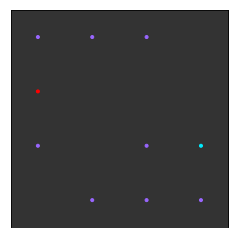

In [107]:
test = Disease(4, num_agents=10)
viewer = DiseaseViewer(test)
viewer.draw()
#print(test)
#locs = test.make_locs(2, 2)
#print(locs[3])
#test.look_for_empty_spot((locs[3]))

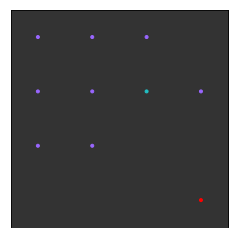

In [100]:
test.step()
viewer.draw()

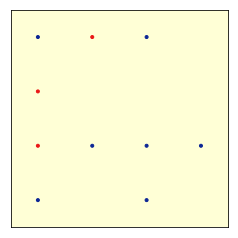

In [67]:
test.step()
viewer.draw()

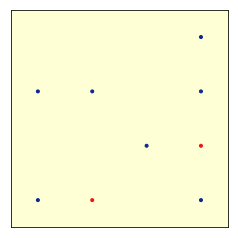

In [68]:
test.step()
viewer.draw()

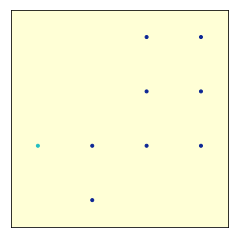

In [37]:
test.step()
viewer.draw()

10
9
1
10


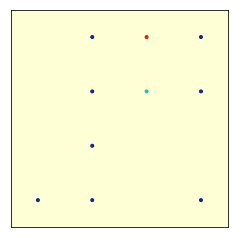

In [38]:
env = Disease(4, num_agents=10, infection_rate=0.9)
viewer = DiseaseViewer(env)
viewer.draw()

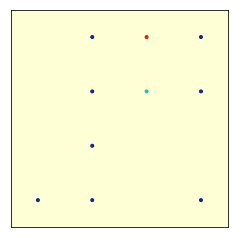

In [39]:
anim = viewer.animate(frames=10, interval=2000)

In [40]:
anim

1250
625
625
1250


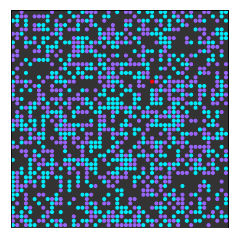

In [133]:
env = Disease(50, num_agents=1250, vaccination_rate=0.5, infection_rate=1, infection_range=3, survival_rate=0.2, infection_time=20)
viewer = DiseaseViewer(env)
viewer.draw()

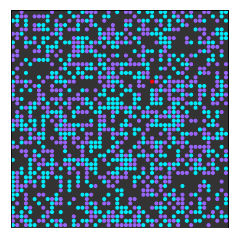

In [134]:
anim = viewer.animate(frames=100, interval=500)

In [135]:
anim